## 业务场景介绍

任务类型：文本分类

任务介绍：由清华大学根据新浪新闻RSS订阅频道2005-2011年间的历史数据筛选过滤，根据文本内容进行分类预测。

数据集内容：
1. 训练集 50000
2. 验证集 5000
3. 测试集 10000
4. 词汇（字） 5000
5. 10个分类，包括：'体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐'


## 模块导包

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models
import re
import numpy as np
from torch import optim
import matplotlib.pyplot as plt
from torchvision import transforms
from collections import defaultdict
import time
import pandas as pd
import os

## txt格式转换工具

In [64]:
class TextTransform():
    def __init__(self, vocabulary_path, labels):
        self.vocab = self.vocab_to_dict(vocabulary_path)
        self.labels = self.labels_to_dict(labels)
    
    # 将词语转换成id
    def vocab_to_dict(self, vocabulary_path):
        with open(vocabulary_path, 'r', encoding='utf-8', errors='ignore') as f:
            vocab_list = f.read().split('\n')
            return dict(zip(vocab_list, range(len(vocab_list))))
    
    # 将标签列表转化成字典
    def labels_to_dict(self, labels):
        return dict(zip(labels, range(len(labels))))
    
    # 文本文件数据转换
    def transform(self, article_path, max_length):
        new_types, articals = self.read_file(article_path)
        X = self.read_content(articals, max_length)
        y = self.labels_to_onehot(new_types)
        return X, y
    
    # 读取txt文件
    def read_file(self, file_path):
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.readlines()   
        new_types = [re.split('[\t|\n]', x)[0] for x in text]
        articals = [re.split('[\t|\n]', x)[1] for x in text]
        return new_types, articals
    
    # 将文本内容转化成id
    def read_content(self, contents, max_length):
        content_array = np.zeros(shape=(len(contents), max_length))
        for idx, content in enumerate(contents):
            content_id_list = [self.vocab[x] for x in content if x in self.vocab][:max_length]
            # pad操作
            content_len = len(content_id_list)
            if content_len != max_length:
                content_id_list = [0 for x in range(max_length-content_len)] + content_id_list
            content_array[idx] = content_id_list
        return content_array
    
    # 将标签转化成onehot编码
    def labels_to_onehot(self, labels):
        label_array = np.zeros(shape=(len(labels),len(self.labels)))
        for idx, label in enumerate(labels):
            label_id = self.labels[label]
            label_array[idx, label_id] = 1
        return label_array

## RNN模型（Embedding + RNN / LSTM / GRU + MLP）

In [27]:
class RNN(nn.Module):
    def __init__(self, strategy='RNN'):
        super(RNN, self).__init__()
        self.strategy = strategy
        self.embedding = nn.Embedding(5000, 64)
        self.gru = nn.GRU(
            input_size=64,
            hidden_size=128,
            num_layers=2,
            bidirectional=True,
            bias=True
        )
        
        self.rnn = nn.RNN(
            input_size=64,
            hidden_size=128,
            num_layers=2,
            bidirectional=True,
            bias=True
        )
        
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=128,
            num_layers=2,
            bidirectional=True,
            bias=True
        )
        
        self.f1 = nn.Sequential(
            nn.Linear(256, 128),
            nn.Dropout(0.8),
            nn.ReLU(),
        )
        
        self.f2 = nn.Sequential(
            nn.Linear(128,10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.embedding(x)  # 输出的每个batch的每一行代表那个字的embedding向量
        
        if self.strategy == 'RNN':
            x, _ = self.rnn(x)  # 输出所有时间步的状态，和最后一个时间步的隐状态
        if self.strategy == 'GRU':
            x, _ = self.gru(x)  # 输出所有时间步的状态，和最后一个时间步的隐状态
        if self.strategy == 'LSTM':
            x, _ = self.lstm(x)  # 输出所有时间步的状态，和最后一个时间步的隐状态
        
        x = F.dropout(x, p=0.8)
        x_linear = x[:,-1,:]
        x_linear = self.f1(x_linear)
        y = self.f2(x_linear)
        return y

## CNN模型（Embedding + AlexNet + MLP）

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(5000, 500)
        self.Alexnet = models.alexnet()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=(2, 2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(24, 24), stride=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = torch.unsqueeze(x, 1)
        x = self.conv(x)
        x = self.Alexnet(x)
        y = self.fc(x)
        return y

## 数据准备

In [65]:
# 文本数据转换
labels_list = ['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐']
txt_transform = TextTransform('./cnews.vocab.txt', labels_list)
x_train, y_train = txt_transform.transform('./cnews.train.txt', max_length=500)
x_val, y_val = txt_transform.transform('./cnews.val.txt', max_length=500)
x_test, y_test = txt_transform.transform('./cnews.test.txt', max_length=500)

# 转换成tensor
x_train_tensor = torch.LongTensor(x_train)[:100]
y_train_tensor = torch.LongTensor(y_train)[:100]

x_val_tensor = torch.LongTensor(x_val)[:100]
y_val_tensor = torch.LongTensor(y_val)[:100]

x_test_tensor = torch.LongTensor(x_test)[:100]
y_test_tensor = torch.LongTensor(y_test)[:100]

y_train_tensor = y_train_tensor.argmax(axis=1)
y_val_tensor = y_val_tensor.argmax(axis=1)
y_test_tensor = y_test_tensor.argmax(axis=1)

# 加载到DataLoader
data_train = TensorDataset(x_train_tensor, y_train_tensor)
dataloader_train = DataLoader(dataset=data_train, batch_size=256, shuffle=True)

data_val = TensorDataset(x_val_tensor, y_val_tensor)
dataloader_val = DataLoader(dataset=data_val, batch_size=256)

data_test = TensorDataset(x_test_tensor, y_test_tensor)
dataloader_test = DataLoader(dataset=data_test, batch_size=256)

## 模型训练

In [66]:
# 训练报告信息保存字典
sumary_dict = {'Model': [], 'Time Per Epoch(s)': [], 'Best Val Accuracy(%)': [], 'Test Accuracy(%)': [], 'File Size(MB)': []}
loss_record = defaultdict(list)
accuracy_record = defaultdict(list)

# 定义超参数
LR = 0.001
EPOCH = 2
model_nn = {'RNN': RNN(strategy='RNN'), 
            'GRU': RNN(strategy='GRU'),
            'LSTM': RNN(strategy='LSTM'),
#             'CNN': CNN()
           }

for name in model_nn:
    
    # 初始化信息记录
    val_best_accuracy = 0
    time_record = 0
    
    # 加载模型
    model = model_nn[name]
    save_path = '{}_beat_model.pt'.format(name)
    
    # 加载GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # 损失函数、优化器
    loss_fun = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    for epoch in range(EPOCH):
        start = time.time()
        # 模型训练
        for i, data in enumerate(dataloader_train):
            x, y = data
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fun(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_record[name].append(loss.item())
        
        # 保存验证集效果最好的模型
        samples = 0
        correct = 0
        for data in dataloader_val:
            x, y = data
            x, y = x.to(device), y.to(device)
            out = model(x).argmax(axis=1)
            correct += (out==y).sum().item()
            samples += out.size()[0]
        accuracy = correct/samples
        accuracy_record[name].append(accuracy)
        if val_best_accuracy < accuracy:
            torch.save(model, save_path)
            val_best_accuracy = accuracy

        end = time.time()
        time_record += (end - start) / EPOCH
        
        # 输出训练情况
        print('{}: epoch({}), val accuracy:{:.2f}%, epoch time:{:.2f}s, val_accuracy{:.2f}'.format(
            name, epoch, accuracy*100, end-start), accuracy)
    
    # 信息保存
    sumary_dict['Model'].append(name)
    sumary_dict['Time Per Epoch(s)'].append(round(time_record,2))
    sumary_dict['Best Val Accuracy(%)'].append(val_best_accuracy)

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


RNN: epoch(0), val accuracy:2.00%, epoch time:2.77s
RNN: epoch(1), val accuracy:2.00%, epoch time:2.69s
GRU: epoch(0), val accuracy:18.00%, epoch time:4.05s
GRU: epoch(1), val accuracy:35.00%, epoch time:4.10s
LSTM: epoch(0), val accuracy:57.00%, epoch time:4.44s
LSTM: epoch(1), val accuracy:75.00%, epoch time:4.41s


## 训练情况

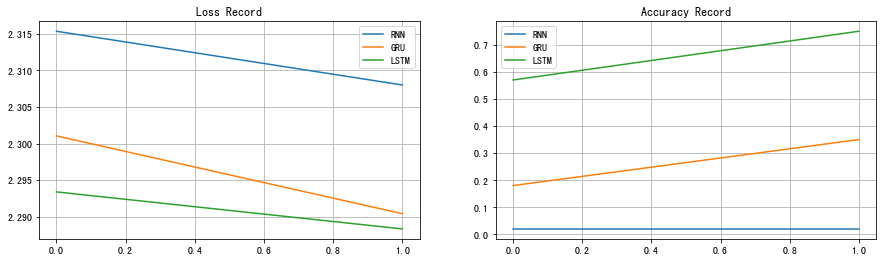

In [67]:
# 查看损失函数和验证集准确率情况
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
for name in loss_record:
    axs[0].plot(loss_record[name], label=name)
    axs[0].legend(loc='best')
    axs[0].grid()
    axs[0].set_title('Loss Record')
    axs[1].plot(accuracy_record[name], label=name)
    axs[1].legend(loc='best')
    axs[1].grid()
    axs[1].set_title('Accuracy Record')

plt.show()

## 模型总结

In [68]:
for model_name in model_nn.keys():
    model_path = './{}_beat_model.pt'.format(model_name)
    model = torch.load(model_path)
    samples = 0
    correct = 0
    for data in dataloader_test:
        x, y = data
        x, y = x.to(device), y.to(device)
        out = model(x).argmax(axis=1)
        correct += (out==y).sum().item()
        samples += out.size()[0]
        test_accuracy = round(correct/samples, 2)
    
    sumary_dict['Test Accuracy(%)'].append(test_accuracy)
    sumary_dict['File Size(MB)'].append(round(os.path.getsize(model_path)/1000000, 2))

pd.DataFrame(sumary_dict)

,Model,Time Per Epoch(s),Best Val Accuracy(%),Test Accuracy(%),File Size(MB)
0,RNN,2.73,0.02,0.05,6.22
1,GRU,4.07,0.35,0.26,6.22
2,LSTM,4.43,0.75,0.81,6.22
